<a href="https://colab.research.google.com/github/SalomonMalka/Black-and-white-image-colorization/blob/Salomon/Black_and_white_image_colorization_RGB_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization with U-Net and GAN Tutorial - Version RGB

# 1 - Imports and data loading

In [3]:
!pip install piqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from scipy.stats import wasserstein_distance

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import piqa
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1 - Imports in colab

The following code install fastai, a library needed essentially in this project to use the COCO database.

In [5]:
!pip install fastai==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The following will download about 20,000 images from COCO dataset.

In [6]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [31]:
if use_colab == True:
    path = coco_path
else:
    path = "/coco_dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 5_000, replace=False) # choosing 10_000 images randomly
rand_idxs = np.random.permutation(5_000)
train_idxs = rand_idxs[:3000] # choosing the first 8000 as training set
val_idxs = rand_idxs[3000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(f"Size of train and validation set: {len(train_paths)}, {len(val_paths)}")

Size of train and validation set: 3000, 2000


Print some images from the train dataset

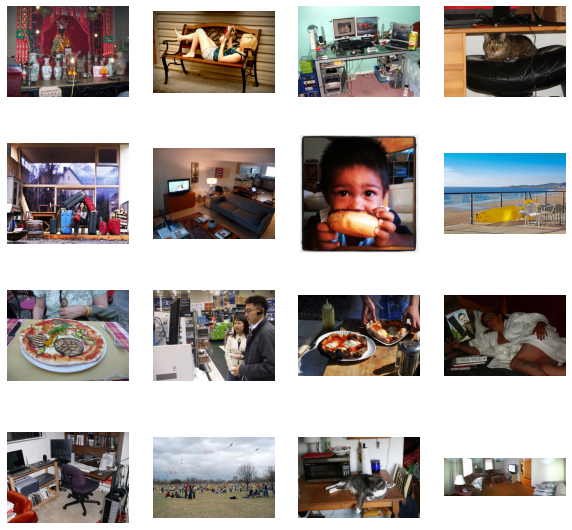

In [32]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2 - Making Datasets and DataLoaders

We separate the data into **L\*a\*b** channels. The **L** channel will be the **black-and-white** images and the **a*b** channels we aim to **predict**.

In [33]:
SIZE = 128
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        color = transforms.ToTensor()(img)
        
        return {'L': L, 'color': color}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

Create train and validation dataloader

In [49]:


train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

# print the dimention of the data
data = next(iter(train_dl))
Ls, colors_ = data['L'], data['color']
print("L channel image shape :", Ls.shape)
print("color channel image shape :", colors_.shape)
print(f"Lenght of train and validation set batches: {len(train_dl)}, {len(val_dl)}")

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


L channel image shape : torch.Size([16, 1, 128, 128])
color channel image shape : torch.Size([16, 3, 128, 128])
Lenght of train and validation set batches: 188, 125


Plot the L, a and b channel of an image from the data. 

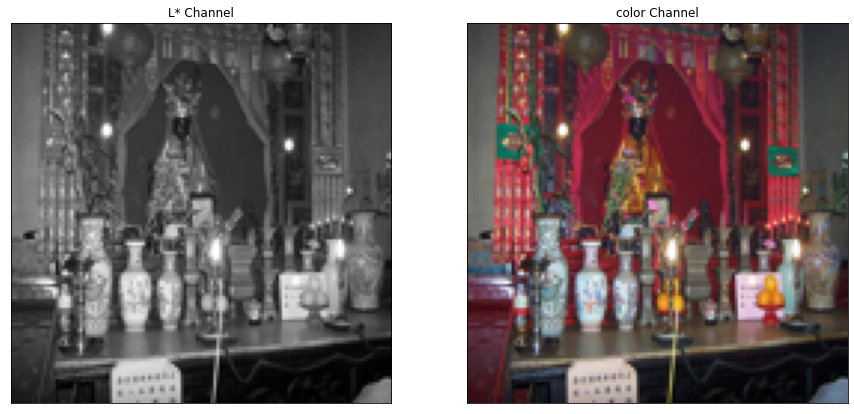

In [35]:
import matplotlib.colors as colors


data = next(iter(train_dl))
data['L'].shape

L_channel = data['L'][0][0]
color_channel = data['color'][0]

fig, axes = plt.subplots(1, 2, figsize = (15,15))
axes[0].imshow(L_channel, cmap = 'gray')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("L* Channel")

axes[1].imshow(color_channel.permute(1,2,0))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("color Channel")

plt.savefig("Lab_channel_example.jpg")
plt.show()


### 1.3 Losses - example

In [36]:
# class GaussianHistogram(nn.Module):
#     def __init__(self, bins, min, max, sigma):
#         super(GaussianHistogram, self).__init__()
#         self.bins = bins
#         self.min = min
#         self.max = max
#         self.sigma = sigma
#         self.delta = float(max - min) / float(bins)
#         self.centers = float(min) + self.delta * (torch.arange(bins).float() + 0.5)

#     def forward(self, x):
#         x = torch.unsqueeze(x, 0) - torch.unsqueeze(self.centers, 1)
#         x = torch.exp(-0.5*(x/self.sigma)**2) / (self.sigma * np.sqrt(np.pi*2)) * self.delta
#         x = x.sum(dim=1)
#         return x

# gausshist = GaussianHistogram(bins=10, min=0, max=100, sigma=6)


# gausshist(data["color"])

# 2 - Create the model

### 2.0 - Utility functions

In [37]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

### 2.1 - Main Model 

We use fastai and torchvision model to create a Unet composed with resnet18 architechture as the encoder part.  

In [38]:
#!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [39]:
def ResUnet(n_input=1, n_output=2, size=SIZE):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    for param in body.parameters():
      param.requires_grad = False
    net_G = DynamicUnet(body, n_output, (size, size), y_range=(0,1)).to(device)
    return net_G

### 2.2 Training the model

In [40]:
save_rep = 'MSE_training/'

if not os.path.exists(save_rep):
  os.makedirs(save_rep)

def visualize_images(L, ab, preds, save = False, title = ''):
  fake_image = lab_to_rgb(L,preds)
  real_image = lab_to_rgb(L,ab)
  # plot the images
  fig = plt.figure(figsize=(15, 8))
  for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(fake_image[i])
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(real_image[i])
    ax.axis("off")
  if save:
    plt.savefig(save_rep+title+'.jpg')

def visualize_images_RGB(L,original, preds, save = False, title = ''):
  original_image = original.cpu()
  predicted_image = preds.cpu()

  # plot the images
  fig = plt.figure(figsize=(15, 8))
  for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(predicted_image[i].permute(1,2,0))
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(original_image[i].permute(1,2,0))
    ax.axis("off")
  plt.show()
  if save:
    plt.savefig(save_rep+title+'.jpg')

In [41]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [42]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [45]:
import torchvision.models as models
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

model initialized with norm initialization


  0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


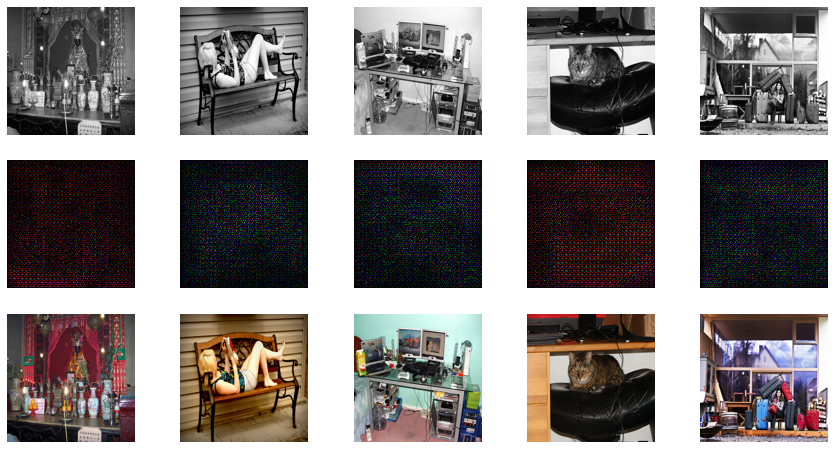

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

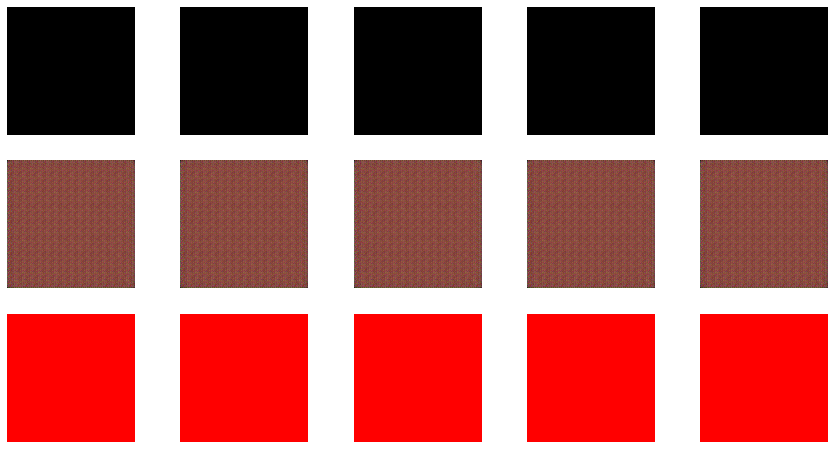

Epoch 1/10
Loss: 14.14190


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

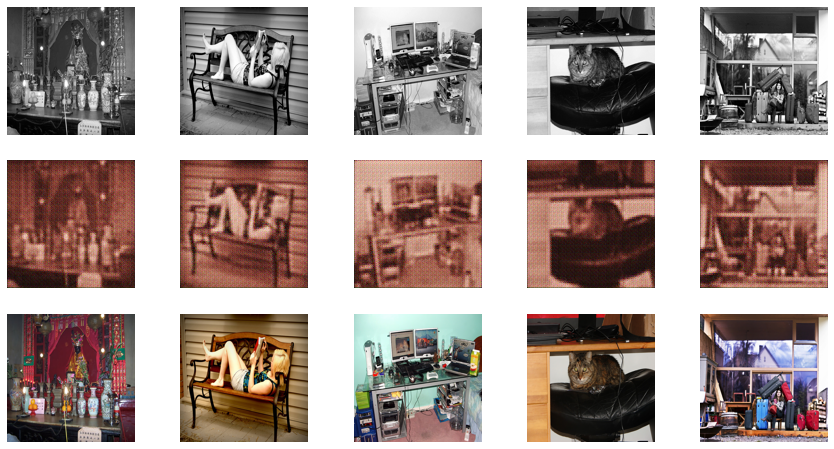

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

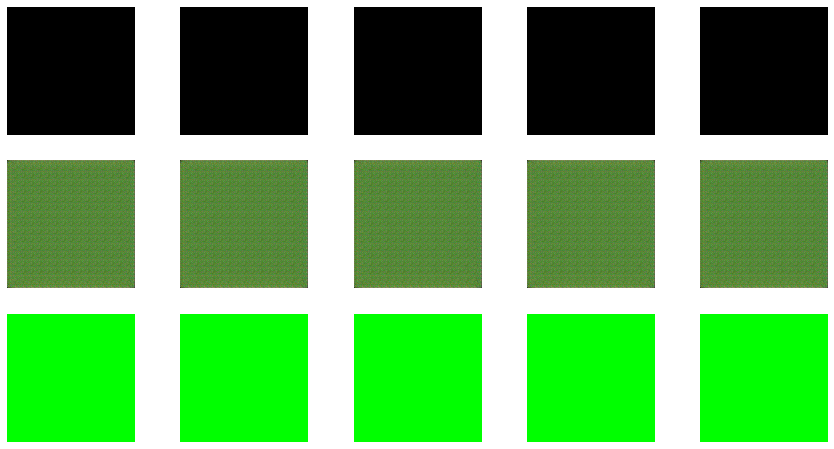

Epoch 2/10
Loss: 6.94276


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

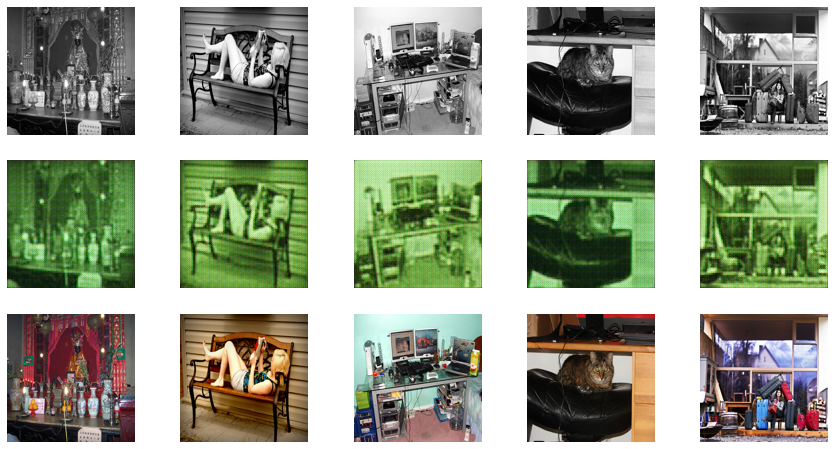

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

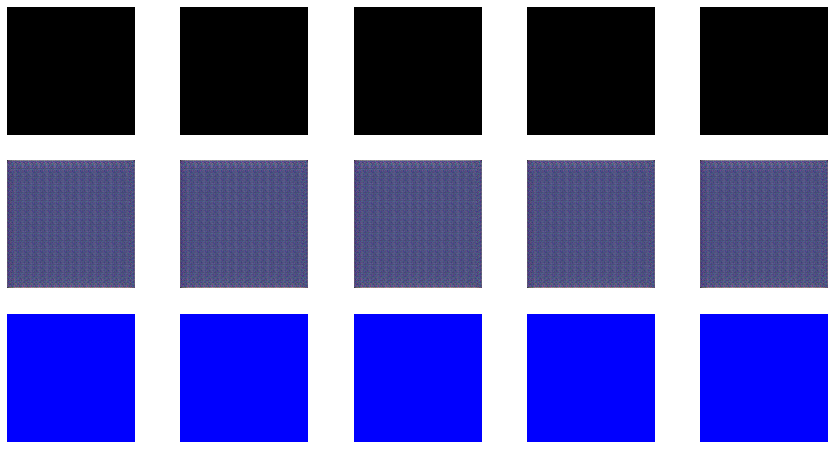

Epoch 3/10
Loss: 6.88176


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

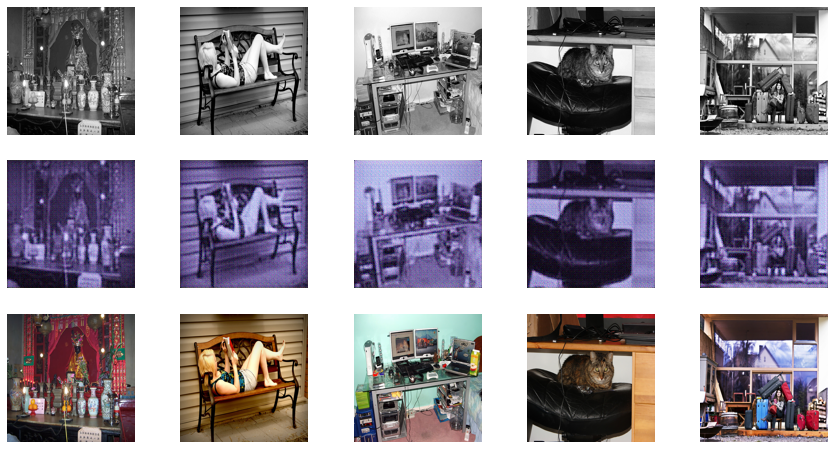

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

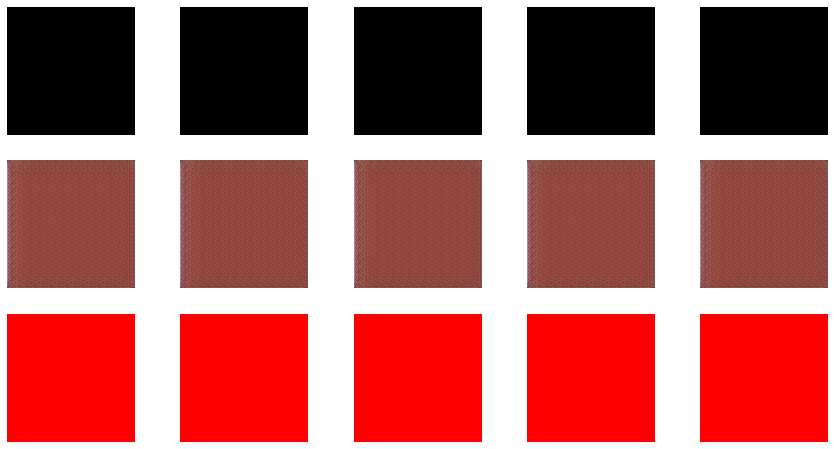

Epoch 4/10
Loss: 6.22009


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

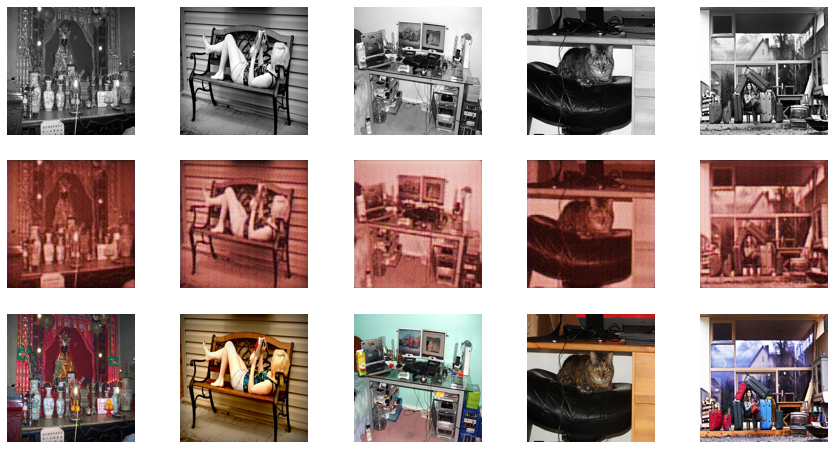

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

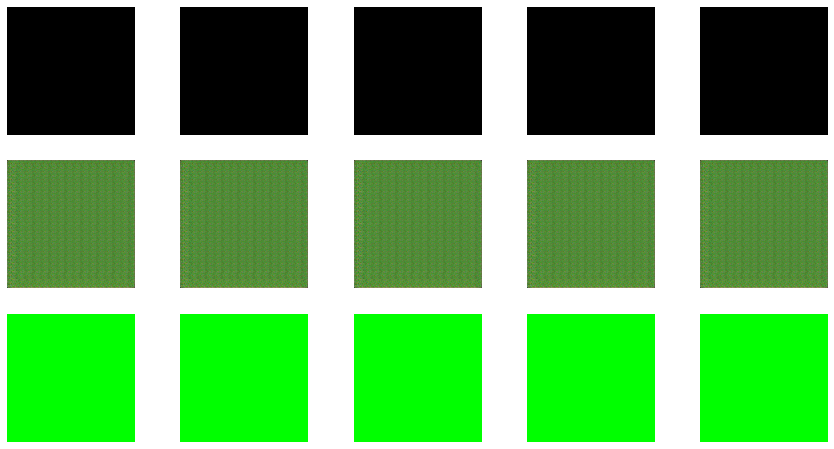

Epoch 5/10
Loss: 6.13926


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

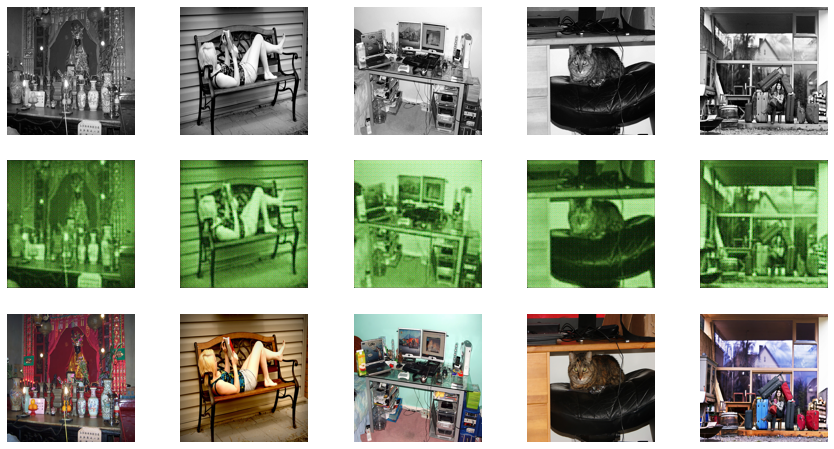

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

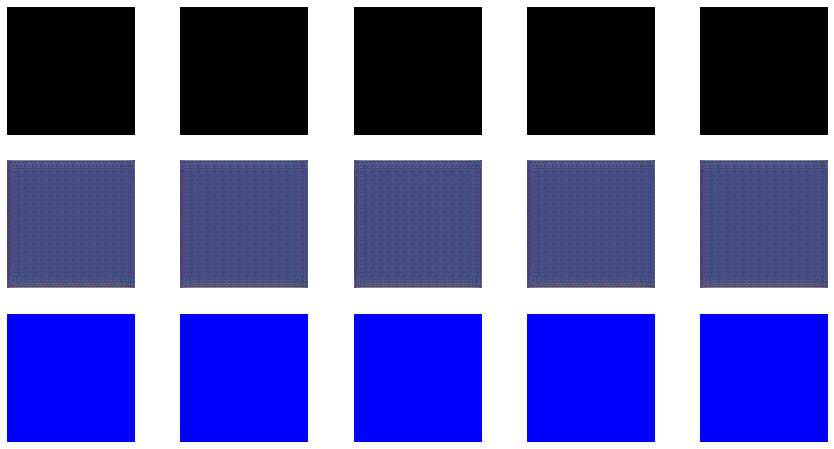

Epoch 6/10
Loss: 6.29961


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

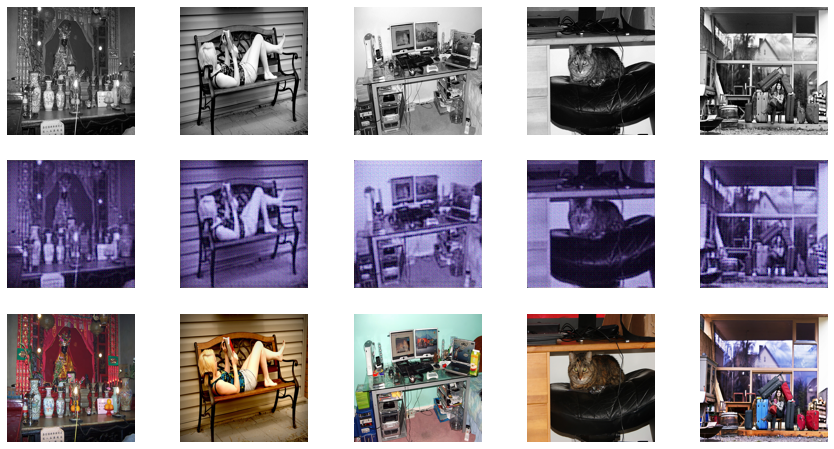

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

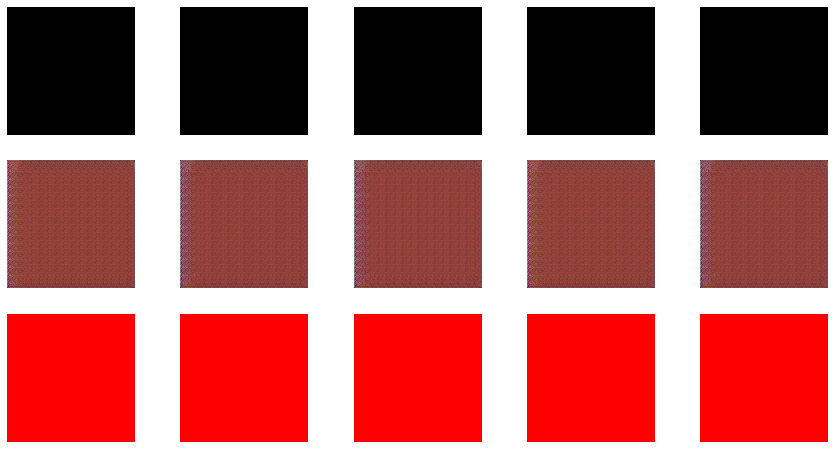

Epoch 7/10
Loss: 5.81296


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

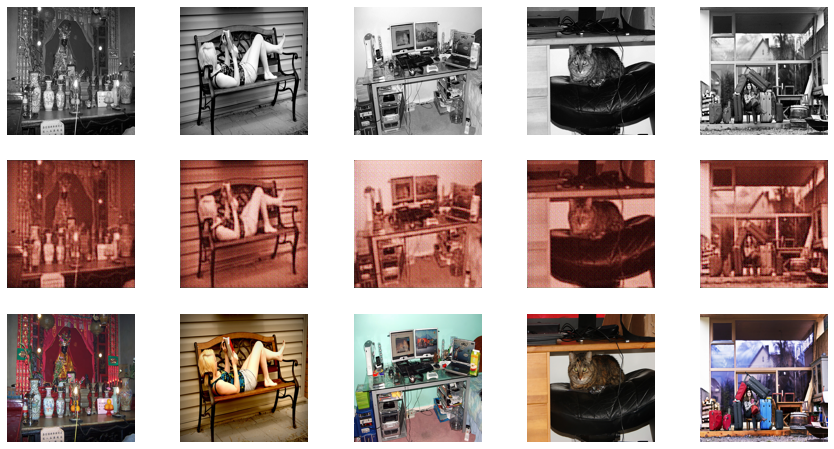

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

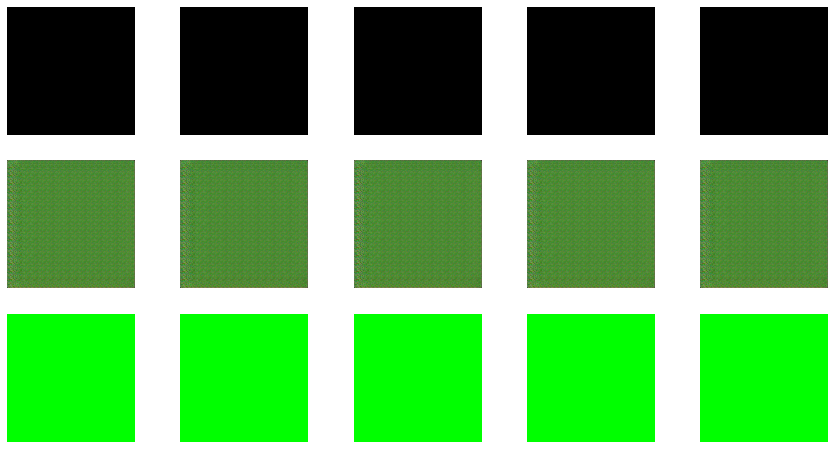

Epoch 8/10
Loss: 5.82836


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

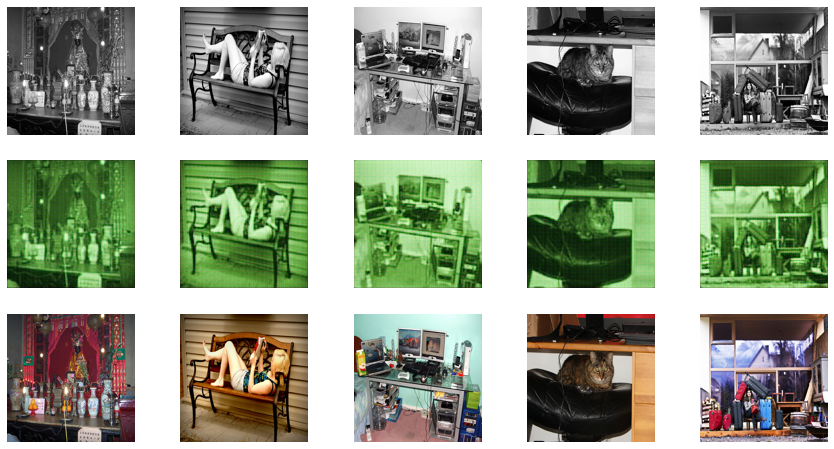

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

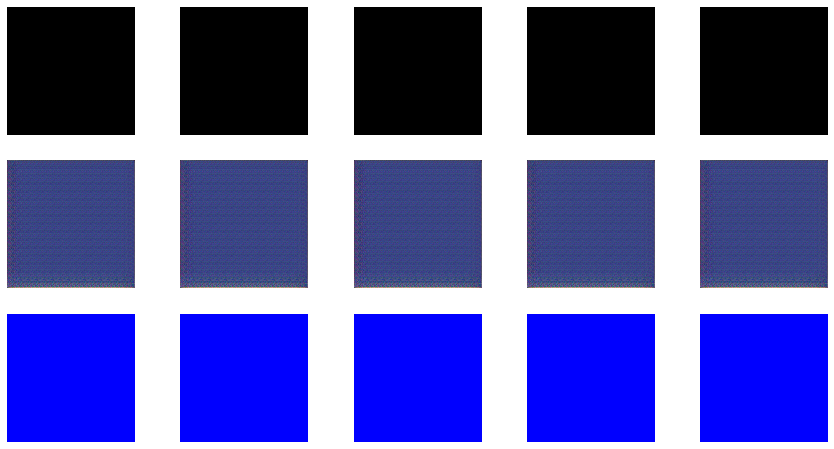

Epoch 9/10
Loss: 5.96174


  0%|          | 0/188 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

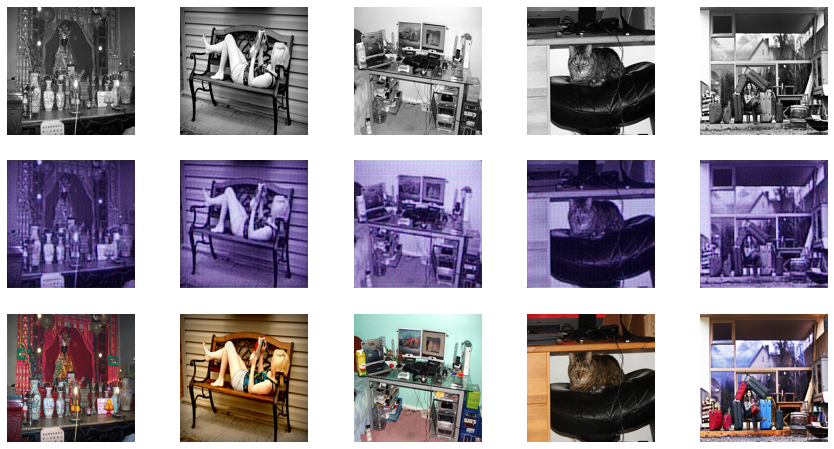

L1 Loss: 0.00000


  0%|          | 0/10 [00:00<?, ?it/s]

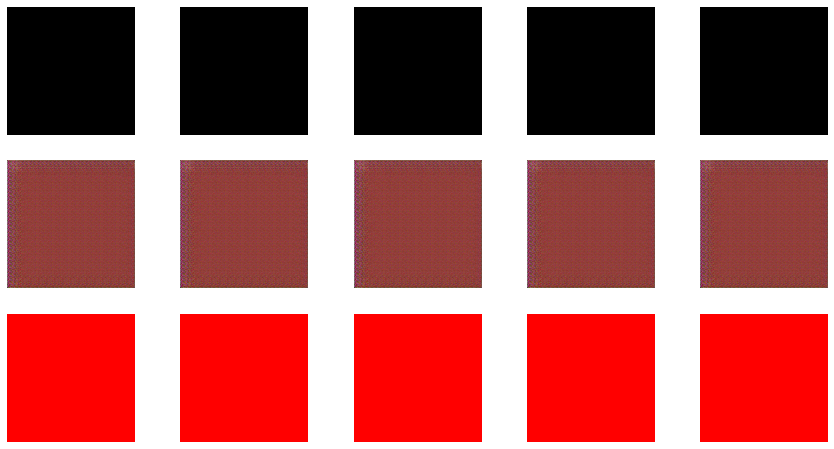

Epoch 10/10
Loss: 5.62052


<Figure size 432x288 with 0 Axes>

In [60]:
L1_distance_array = []
L1_val_array = []
MSE_distance_array = []

L2param = 200.

def train_model(model, train_dl, opt, criterion, epochs, val_dl, visualize_every = 200):
  for e in range(epochs):
    loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    counter = 0
    for data in tqdm(train_dl):
      L, color = data['L'].to(device), data['color'].to(device)
      preds = model(L)

      #print(f"preds -------------- min {torch.min(preds)},max {torch.max(preds)}")
      #print(f"origs -------------- min {torch.min(color)},max {torch.max(color)}")

      # visualize predicted images and loss every visualize_every cycles
      if counter % visualize_every == 0:
        visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = False)      
        print(f"L1 Loss: {loss_meter.avg:.5f}")
      counter += 1
      
      loss = criterion(preds, color) + L2param * nn.MSELoss()(preds, color)
      L1_loss = nn.L1Loss()(preds.detach(), color.detach())
      MSE_loss = nn.MSELoss()(preds.detach(), color.detach())
      opt.zero_grad()
      loss.backward()
      opt.step()
      loss_meter.update(loss.item(), L.size(0))
      
      # save different losses
      L1_distance_array.append(L1_loss.item())
      MSE_distance_array.append(MSE_loss.item())
    for _ in tqdm(range(10)):
      L = torch.zeros(16,1,128,128).to(device)
      r = 1 if e%3 == 0 else 0
      g = 1 if e%3 == 1 else 0
      b = 1 if e%3 == 2 else 0
      color = torch.cat([r*torch.ones(16,1,128,128),g*torch.ones(16,1,128,128),b*torch.ones(16,1,128,128)],dim=1).to(device)
      preds = model(L)

      #print(f"preds -------------- min {torch.min(preds)},max {torch.max(preds)}")
      #print(f"origs -------------- min {torch.min(color)},max {torch.max(color)}")

      # visualize predicted images and loss every visualize_every cycles
      if counter % visualize_every == 0:
        visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = False)      
        print(f"L1 Loss: {loss_meter.avg:.5f}")
      counter += 1
      
      loss = criterion(preds, color) + L2param * nn.MSELoss()(preds, color)
      L1_loss = nn.L1Loss()(preds.detach(), color.detach())
      MSE_loss = nn.MSELoss()(preds.detach(), color.detach())
      opt.zero_grad()
      loss.backward()
      opt.step()
      loss_meter.update(loss.item(), L.size(0))
      
      # save different losses
      L1_distance_array.append(L1_loss.item())
      MSE_distance_array.append(MSE_loss.item())

    visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = True, title = str(e))
    print(f"Epoch {e + 1}/{epochs}")
    print(f"Loss: {loss_meter.avg:.5f}")

torch.cuda.empty_cache()
#unet = ResUnet(n_input=1, n_output=3, size=SIZE)
unet = init_model(Unet(input_c=1, output_c=3, n_down=4, num_filters=32), device)
#unet = ColorizationNet().to(device)
beta1 = 0.5
beta2 = 0.999
opt = optim.Adam(unet.parameters(), lr=1e-4, betas = (beta1,beta2))
#criterion = piqa.LPIPS(network='vgg').to(device)
criterion = VGGPerceptualLoss().to(device)
num_epochs = 10
train_model(unet, train_dl, opt, criterion, num_epochs, val_dl)
torch.save(unet.state_dict(), "res18-unet_3.pt")

torch.Size([16, 3, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

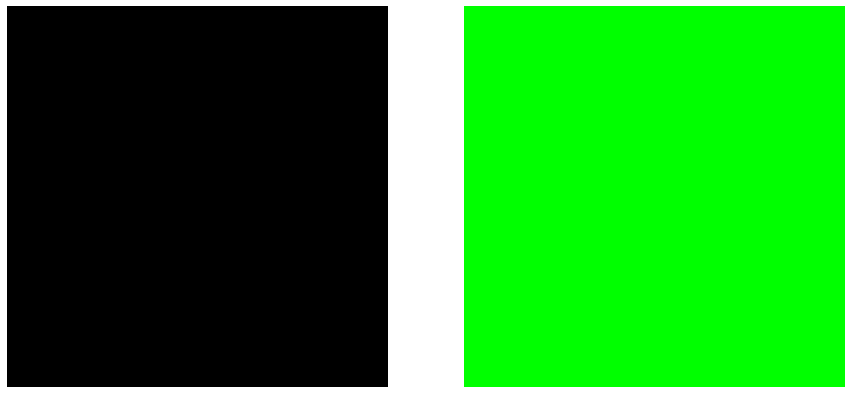

In [58]:
L = torch.zeros(16,1,128,128)
color = torch.cat([torch.zeros(16,1,128,128),torch.ones(16,1,128,128),torch.zeros(16,1,128,128)],dim=1)
preds = L

print(color.shape)

#print(f"preds -------------- min {torch.min(preds)},max {torch.max(preds)}")
#print(f"origs -------------- min {torch.min(color)},max {torch.max(color)}")

# visualize predicted images and loss every visualize_every cycles
#visualize_images_RGB(L.detach(),color.detach(),preds.detach(), save = False)

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 2, 1)
ax.imshow(L[0][0].cpu(), cmap='gray')
ax.axis("off")
ax = plt.subplot(1, 2, 2)
ax.imshow(color[0].permute(1,2,0))
ax.axis("off")


In [ ]:
plt.figure()
plt.plot(L1_distance_array)
plt.plot(MSE_distance_array)

### 2.3 - Load previously trained model

In [ ]:
unet.load_state_dict(torch.load("res18-unet.pt", map_location=device))

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=3edb1e562f45586ec765272090af60c54753a18cea48f168f78ed045b16b85b0
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
from torchviz import make_dot

x = torch.randn(SIZE, SIZE).view(1,1,SIZE,SIZE).to(device)
make_dot(unet(x), params=dict(unet.named_parameters()))

In [ ]:
str(10)

'10'